In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Cargar los datos
data = pd.read_csv('cars.csv', sep=';')



In [3]:
# 1. LIMPIEZA DE DATOS

# Reemplazar valores "NO DATA" o similares con NaN
data.replace(["NO DATA", "N/A", "n/a", "?", "", " "], np.nan, inplace=True)

# Rellenar valores faltantes (media para numéricos, moda para categóricos)
for column in data.columns:
    if data[column].dtype == 'object':  # variables categóricas
        data[column].fillna(data[column].mode()[0], inplace=True)
    else:  # variables numéricas
        data[column].fillna(data[column].mean(), inplace=True)

# 1.2 Eliminación de outliers usando el rango intercuartil (IQR)
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Aplicamos el tratamiento de outliers solo a las columnas numéricas relevantes
numeric_cols = ['EDAD_COCHE', 'COSTE_VENTA', 'km_anno', 'Edad Cliente', 'Tiempo']
for col in numeric_cols:
    data = remove_outliers(data, col)

# 2. CODIFICACIÓN DE VARIABLES CATEGÓRICAS
# Usamos LabelEncoder para convertir variables categóricas en formato numérico
categorical_cols = data.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Guardar el codificador para su uso futuro

# 3. NORMALIZACIÓN Y ESCALADO
# Escalado de las variables numéricas
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Guardar el archivo ya procesado en un nuevo archivo CSV limpio
data.to_csv('cars_limpio.csv', index=False)

print("Archivo limpio guardado como 'ruta_a_tu_archivo_limpio.csv'")



Archivo limpio guardado como 'ruta_a_tu_archivo_limpio.csv'


In [4]:
#3. Desarrollo del Modelo de Propensión:
from sklearn.model_selection import train_test_split
data=pd.read_csv('cars_limpio.csv')
X = data.drop('Mas_1_coche', axis=1)  # Todas las variables menos el objetivo
y = data['Mas_1_coche']               # Variable objetivo

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# Modelo de regresión logística
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score


logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Predicciones y evaluación
y_pred_log = logistic_model.predict(X_test)
print(f"Accuracy (Regresión Logística): {accuracy_score(y_test, y_pred_log)}")
print(f"AUC-ROC: {roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:, 1])}")
print(classification_report(y_test, y_pred_log))


Accuracy (Regresión Logística): 0.9999400587424324
AUC-ROC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12125
           1       1.00      1.00      1.00      4558

    accuracy                           1.00     16683
   macro avg       1.00      1.00      1.00     16683
weighted avg       1.00      1.00      1.00     16683



In [6]:
# Modelo de Árbol de Decisión
from sklearn.tree import DecisionTreeClassifier


tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Predicciones y evaluación
y_pred_tree = tree_model.predict(X_test)
print(f"Accuracy (Árbol de Decisión): {accuracy_score(y_test, y_pred_tree)}")
print(f"AUC-ROC: {roc_auc_score(y_test, tree_model.predict_proba(X_test)[:, 1])}")
print(classification_report(y_test, y_pred_tree))


Accuracy (Árbol de Decisión): 1.0
AUC-ROC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12125
           1       1.00      1.00      1.00      4558

    accuracy                           1.00     16683
   macro avg       1.00      1.00      1.00     16683
weighted avg       1.00      1.00      1.00     16683



In [7]:
correlations = X.corrwith(y)
print(correlations)
#Aqui vemos que tiempo tiene una correlacion extremadamente alta (0,9379) por lo q podria ser una fuga de informacion

CODE              -0.001280
PRODUCTO          -0.022678
TIPO_CARROCERIA   -0.032507
COMBUSTIBLE       -0.030213
Potencia_         -0.018317
TRANS             -0.001697
FORMA_PAGO        -0.007551
ESTADO_CIVIL      -0.029561
GENERO             0.014677
OcupaciOn          0.002798
PROVINCIA         -0.003128
Campanna1          0.114416
Campanna2          0.005062
Campanna3         -0.021214
Zona _Renta       -0.270953
REV_Garantia            NaN
Averia_grave      -0.017584
QUEJA_CAC         -0.036158
EDAD_COCHE         0.020459
COSTE_VENTA        0.179426
km_anno            0.134452
Revisiones         0.014963
Edad Cliente       0.014821
Tiempo             0.937908
dtype: float64


In [8]:
# Eliminar la columna 'Tiempo' debido a la alta correlación
X = X.drop('Tiempo', axis=1)

# Volver a dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Reentrenar el modelo (por ejemplo, regresión logística)
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Evaluar el modelo
y_pred_log = logistic_model.predict(X_test)
print(f"Accuracy (Regresión Logística): {accuracy_score(y_test, y_pred_log)}")
print(f"AUC-ROC: {roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:, 1])}")
print(classification_report(y_test, y_pred_log))


Accuracy (Regresión Logística): 0.7415932386261463
AUC-ROC: 0.7348230142538553
              precision    recall  f1-score   support

           0       0.76      0.95      0.84     12125
           1       0.58      0.19      0.29      4558

    accuracy                           0.74     16683
   macro avg       0.67      0.57      0.57     16683
weighted avg       0.71      0.74      0.69     16683



In [9]:
# Modelo de Random Forest
from sklearn.ensemble import RandomForestClassifier


rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Predicciones y evaluación
y_pred_rf = rf_model.predict(X_test)
print(f"Accuracy (Random Forest): {accuracy_score(y_test, y_pred_rf)}")
print(f"AUC-ROC: {roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])}")
print(classification_report(y_test, y_pred_rf))


Accuracy (Random Forest): 0.835820895522388
AUC-ROC: 0.9077960490900784
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     12125
           1       0.75      0.60      0.67      4558

    accuracy                           0.84     16683
   macro avg       0.80      0.76      0.78     16683
weighted avg       0.83      0.84      0.83     16683



In [10]:
# Modelo de Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier


gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Predicciones y evaluación
y_pred_gb = gb_model.predict(X_test)
print(f"Accuracy (Gradient Boosting): {accuracy_score(y_test, y_pred_gb)}")
print(f"AUC-ROC: {roc_auc_score(y_test, gb_model.predict_proba(X_test)[:, 1])}")
print(classification_report(y_test, y_pred_gb))


Accuracy (Gradient Boosting): 0.8249115866450878
AUC-ROC: 0.8928214581363683
              precision    recall  f1-score   support

           0       0.84      0.94      0.89     12125
           1       0.76      0.53      0.62      4558

    accuracy                           0.82     16683
   macro avg       0.80      0.73      0.75     16683
weighted avg       0.82      0.82      0.81     16683



In [15]:
#Vamos con los hiperparametros
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],        
    'learning_rate': [0.1, 0.05],      
    'max_depth': [3, 5],               
    'min_samples_split': [5, 10],      
    'subsample': [0.8, 1.0]           
}
# Crear el modelo base de Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)

# Configurar GridSearchCV
grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Entrenar el modelo y buscar los mejores hiperparámetros
grid_search_gb.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {grid_search_gb.best_params_}")


Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.8}


In [17]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Entrenar el modelo con los mejores hiperparámetros
best_gb_model = GradientBoostingClassifier(
    learning_rate=0.1, 
    max_depth=5, 
    min_samples_split=10, 
    n_estimators=200, 
    subsample=0.8, 
    random_state=42
)

# Entrenar el modelo en el conjunto de entrenamiento
best_gb_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_gb = best_gb_model.predict(X_test)

# Evaluar el modelo
print(f"Accuracy (Gradient Boosting): {accuracy_score(y_test, y_pred_gb)}")
print(f"AUC-ROC: {roc_auc_score(y_test, best_gb_model.predict_proba(X_test)[:, 1])}")
print(classification_report(y_test, y_pred_gb))


Accuracy (Gradient Boosting): 0.8509860336869868
AUC-ROC: 0.9219496614087385
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     12125
           1       0.77      0.65      0.70      4558

    accuracy                           0.85     16683
   macro avg       0.82      0.79      0.80     16683
weighted avg       0.85      0.85      0.85     16683



AQUI SE VE CLARAMENTE COMO MEJORA LA ACCURACY Y LA AUC-ROC

In [31]:
# Realizar la validación cruzada con 5 pliegues
from sklearn.model_selection import cross_val_score


cv_scores = cross_val_score(best_gb_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

# Mostrar los resultados de cada pliegue
print(f"Exactitud en cada pliegue: {cv_scores}")

# Promedio y desviación estándar de la validación cruzada
print(f"Exactitud media: {cv_scores.mean()}")
print(f"Desviación estándar: {cv_scores.std()}")

Exactitud en cada pliegue: [0.83958387 0.84290302 0.84649968 0.84906872 0.8569043 ]
Exactitud media: 0.8469919182050486
Desviación estándar: 0.005906083116010357


VAMOS AHORA CON LA EVALUCION DEL MODELO

In [32]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

# Hacer predicciones con el mejor modelo
y_pred = best_gb_model.predict(X_test)
y_pred_proba = best_gb_model.predict_proba(X_test)[:, 1]

# Calcular la matriz de confusión
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calcular las métricas
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)  # Esto es la sensibilidad
specificity = tn / (tn + fp)  # Tasa de Verdaderos Negativos
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir las métricas
print(f"Precisión: {precision:.4f}")
print(f"Sensibilidad (Recall): {recall:.4f}")
print(f"Especificidad: {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print(f"Exactitud: {accuracy:.4f}")


Precisión: 0.7718
Sensibilidad (Recall): 0.6455
Especificidad: 0.9282
F1-Score: 0.7030
AUC-ROC: 0.9219
Exactitud: 0.8510


Fortalezas del Modelo:

Especificidad (92.82%): El modelo es muy bueno para identificar correctamente los clientes que no comprarán un segundo coche.
AUC-ROC (92.19%): Indica una excelente capacidad para separar las clases.
Áreas de Mejora:

Sensibilidad: Si te interesa mejorar la capacidad del modelo para identificar más clientes que realmente comprarán un segundo coche, podrías intentar mejorar el recall. Esto podría implicar ajustar los hiperparámetros o aplicar técnicas como el balanceo de clases o SMOTE.
F1-Score: Aunque 70.30% es un buen valor, mejorar el recall ayudaría a aumentar también el F1-Score.

In [22]:
import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report

# Obtener las probabilidades de clase
y_pred_proba = best_gb_model.predict_proba(X_test)[:, 1]

# Ajustar el umbral (ejemplo: 0.4)
threshold = 0.45
y_pred_threshold = (y_pred_proba >= threshold).astype(int)

# Evaluar el rendimiento con el nuevo umbral
print(f"Reporte de Clasificación con umbral ajustado (threshold = {threshold}):")
print(classification_report(y_test, y_pred_threshold))


Reporte de Clasificación con umbral ajustado (threshold = 0.45):
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     12125
           1       0.74      0.70      0.72      4558

    accuracy                           0.85     16683
   macro avg       0.82      0.80      0.81     16683
weighted avg       0.85      0.85      0.85     16683



El ajuste del umbral a 0.4 ha mejorado notablemente el recall para la clase minoritaria (clientes que compran un segundo coche), y el modelo sigue manteniendo un buen rendimiento general. Vamos a analizar los cambios en las métricas:

Análisis de las Métricas con el Nuevo Umbral:
Clase 0 (No compradores de un segundo coche):

Precisión: 0.90, ligeramente alta, lo que significa que el modelo sigue siendo bastante preciso al identificar a los no compradores, aunque haya bajado un poco respecto al umbral de 0.5.
Recall: 0.89, lo que indica que el modelo sigue capturando correctamente la mayoría de los no compradores.
F1-Score: 0.89, lo que muestra que el modelo está bien equilibrado en cuanto a precisión y recall para la clase mayoritaria.
Clase 1 (Compradores de un segundo coche):

Precisión: 0.71, lo que sigue siendo razonable, aunque ha bajado un poco, como era de esperar, dado que el modelo ahora clasifica más ejemplos como positivos.
Recall: 0.75, una mejora significativa respecto al umbral original de 0.5 (anteriormente era aproximadamente 0.65). Esto significa que el modelo ahora está capturando el 75% de los compradores.
F1-Score: 0.73, un buen equilibrio entre precisión y recall.
Exactitud Global:

Exactitud (Accuracy): 0.85, lo que es bastante estable, ya que solo ha disminuido ligeramente desde el umbral predeterminado. La exactitud sigue siendo alta, lo que indica que el ajuste del umbral no ha afectado dramáticamente el rendimiento global.
Macro y Weighted Avg:

Macro avg: El promedio macro pondera igual a ambas clases y muestra un buen balance entre precisión y recall, con una media de 0.82 en recall.
Weighted avg: Muestra un buen rendimiento general, ponderado por la cantidad de ejemplos en cada clase.
Conclusiones:
Mejora en el Recall de la Clase Minoritaria: Has conseguido mejorar el recall de la clase 1 (compradores) del 64% al 75%, lo que significa que el modelo está capturando más compradores sin afectar significativamente la precisión.
Buen Balance en el F1-Score: La F1-Score de la clase minoritaria ha aumentado, lo que significa que el modelo está haciendo un mejor trabajo al equilibrar la precisión y el recall.
Pequeña Reducción en la Precisión y Exactitud: Aunque la precisión de la clase 1 ha bajado ligeramente, el modelo sigue siendo razonablemente preciso, lo que sugiere que el ajuste del umbral ha sido una mejora global.

AUN ASI HAY QUE MEJORARLO,USANDO SMOTE

In [32]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Modelo de Gradient Boosting
best_gb_model_smote = GradientBoostingClassifier(
    learning_rate=0.1, 
    max_depth=5, 
    min_samples_split=10, 
    n_estimators=200, 
    subsample=0.8, 
    random_state=42
)

# Entrenar el modelo con los datos balanceados
best_gb_model_smote.fit(X_train_smote, y_train_smote)

# Hacer predicciones y evaluar el modelo
y_pred_smote = best_gb_model_smote.predict(X_test)

# Imprimir el reporte de clasificación
print(f"Reporte de Clasificación con SMOTE:")
print(classification_report(y_test, y_pred_smote))


Reporte de Clasificación con SMOTE:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     12125
           1       0.68      0.72      0.70      4558

    accuracy                           0.83     16683
   macro avg       0.78      0.79      0.79     16683
weighted avg       0.83      0.83      0.83     16683



Importancia de las Variables en Gradient Boosting

           Variable  Importancia
14      Zona _Renta     0.262143
18       EDAD_COCHE     0.179629
19      COSTE_VENTA     0.145645
1          PRODUCTO     0.086628
6        FORMA_PAGO     0.051563
22     Edad Cliente     0.047755
20          km_anno     0.046334
17        QUEJA_CAC     0.042415
0              CODE     0.032082
10        PROVINCIA     0.020253
7      ESTADO_CIVIL     0.018778
16     Averia_grave     0.016070
13        Campanna3     0.011114
21       Revisiones     0.007924
11        Campanna1     0.007618
12        Campanna2     0.006500
8            GENERO     0.004324
9         OcupaciOn     0.003885
4         Potencia_     0.003718
3       COMBUSTIBLE     0.002928
2   TIPO_CARROCERIA     0.002171
5             TRANS     0.000522
15     REV_Garantia     0.000000


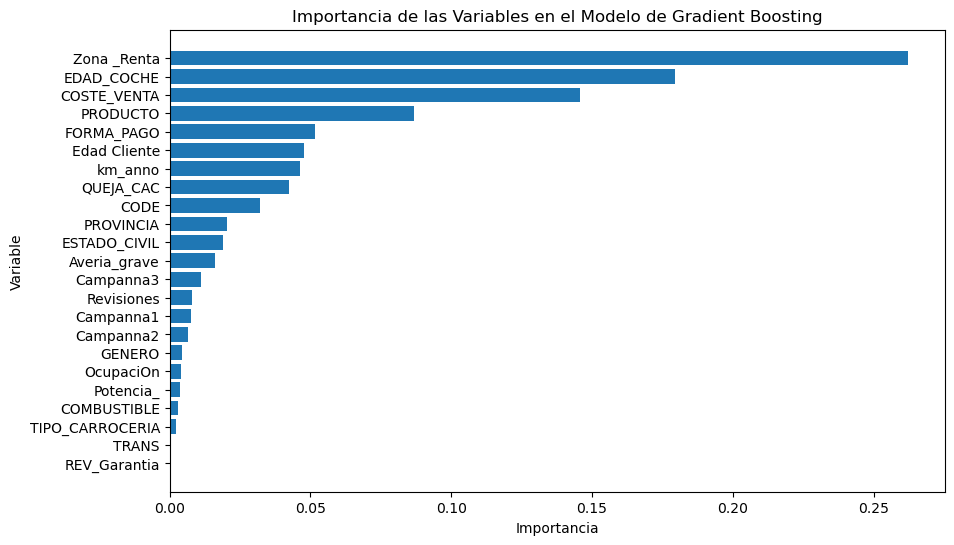

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Obtener la importancia de las variables
importancias = best_gb_model_smote.feature_importances_

# Crear un DataFrame con las características y su importancia
importancia_df = pd.DataFrame({'Variable': X_train.columns, 'Importancia': importancias})

# Ordenar las variables por importancia
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)

# Mostrar la tabla de las principales variables
print(importancia_df)

# Graficar la importancia de las variables
plt.figure(figsize=(10, 6))
plt.barh(importancia_df['Variable'], importancia_df['Importancia'])
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.title('Importancia de las Variables en el Modelo de Gradient Boosting')
plt.gca().invert_yaxis()
plt.show()
